What best values of (a,b,c) and (k,beta) did you find? How did you find them -
What method did you use?

Compare values in different corpus. Are they different?
Quantify difference functions. constant function, typical values for Heaps law

In [1]:
import pandas as pd
import os
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

In [32]:
dataset_names = {"word_counts_novels_clean.txt", 
            "word_counts_news_clean.txt",
            "word_counts_arxiv_abs_clean.txt"}

In [3]:
data = {}

for name in dataset_names:
    data_path = os.path.join(os.getcwd(), "data", name)

    # Assuming your data is in a CSV file with 'word' and 'count' columns
    data[name] = pd.read_csv(data_path, names=['count', 'word'])

    # remove group
    data[name] = data[name].groupby(by="word").sum().reset_index()

In [22]:
n_types = {}
n_words = {}

for name, df in data.items():
    n = len(df)
    sparce = 30

    types_dict = dict()

    for i in range(0, n, sparce):
        m = df.sample(n = i+1, weights="count",replace=True, random_state=123)
        types_dict[i+1] = len(set(m.word))

    n_types[name] = np.array([key for key in types_dict.keys()])
    n_words[name] = np.array([key for key in types_dict.values()])

In [8]:
def Heaps_law(n_words, k, beta):
    return k * (n_words ** beta)

In [55]:
# First fit using Heaps law
k = {}
beta = {}
sigma_ab = {}

for name in data.keys():
    params = curve_fit(Heaps_law, n_words[name], n_types[name], bounds = (0, [np.inf, 1]))
    fits, covar = params
    k[name], beta[name] = fits

    print("Processed dataset:", name)
    print("k=", k[name], "B=",beta[name])

    # approximate the error of the fit
    sigma_ab[name] = np.sqrt(np.diagonal(covar))

Processed dataset: word_counts_news_clean.txt
k= 5.516733422352938 B= 0.9999999999999581
Processed dataset: word_counts_arxiv_abs_clean.txt
k= 6.699972936255415 B= 0.9999999999999908
Processed dataset: word_counts_novels_clean.txt
k= 5.012891792415474 B= 0.9999999999999072


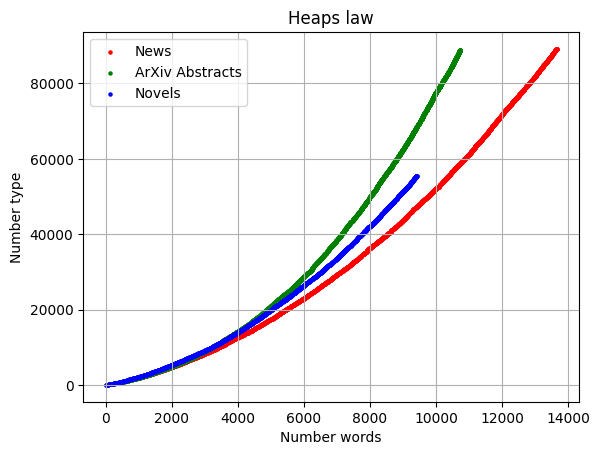

In [72]:
renamed_datasets = {"word_counts_novels_clean.txt" : "Novels", 
            "word_counts_news_clean.txt" : "News",
            "word_counts_arxiv_abs_clean.txt" : "ArXiv Abstracts"}

for name in dataset_names:
    new_name = renamed_datasets[name]

    if new_name == "News":
        col = "red"
    elif new_name == "Novels":
        col = "blue"
    else:
        col = "green"

    plt.scatter(n_words[name], n_types[name], label = new_name, s=5, color=col, marker='o')
    plt.legend()
    plt.grid()
    plt.title("Heaps law")
    plt.xlabel("Number words")
    plt.ylabel("Number type")

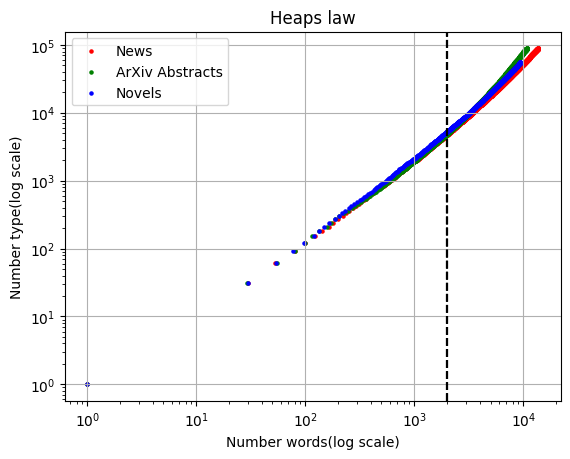

In [35]:
renamed_datasets = {"word_counts_novels_clean.txt" : "Novels", 
            "word_counts_news_clean.txt" : "News",
            "word_counts_arxiv_abs_clean.txt" : "ArXiv Abstracts"}

for name in dataset_names:
    new_name = renamed_datasets[name]

    if new_name == "News":
        col = "red"
    elif new_name == "Novels":
        col = "blue"
    else:
        col = "green"

    plt.scatter(n_words[name], n_types[name], label = new_name, s=5, color=col, marker='o')
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.grid()
    plt.title("Heaps law")
    plt.xlabel("Number words(log scale)")
    plt.ylabel("Number type(log scale)")
    plt.axvline(x=2000, linestyle='--', color = "black")
    

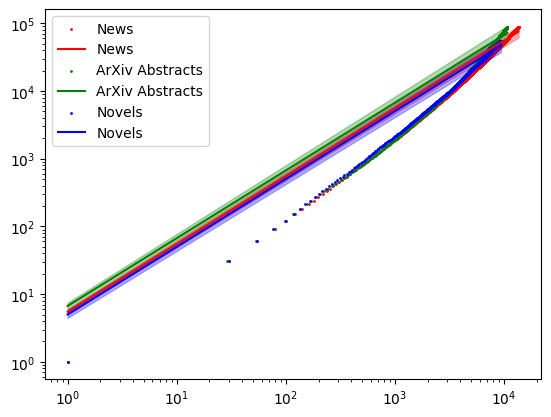

In [67]:
# Plot fitted functions and original points
# it seems not a good fit
for name in data.keys():
    # plot points
    new_name = renamed_datasets[name]

    if new_name == "News":
        col = "red"
    elif new_name == "Novels":
        col = "blue"
    else:
        col = "green"

    plt.scatter(n_words[name], n_types[name], label = new_name, s=1, color=col, marker='o')

    # plot functions
    bound_upper = Heaps_law(n_words[name], *([k[name], beta[name]] + sigma_ab[name]))
    bound_lower = Heaps_law(n_words[name], *([k[name], beta[name]] - sigma_ab[name]))

    # plotting the confidence intervals
    plt.fill_between(n_words[name], bound_lower, bound_upper,
                    color = col, alpha = 0.30)

    plt.plot(n_words[name], Heaps_law(n_words[name], k[name], beta[name]), color = col, label = renamed_datasets[name])

    plt.yscale("log")
    plt.xscale("log") 
    plt.legend()


In [68]:
# Calculate error of the fit
RMSE = {}

for name in data.keys():

    predicted = Heaps_law(n_words[name], *([k[name], beta[name]] + sigma_ab[name]))
    RMSE[name] = root_mean_squared_error(y_true=n_types[name], y_pred = predicted)

array([2005, 2013, 2018, ..., 9409, 9411, 9415])

In [ ]:
# Fit ussing two sections
lim = 2000
k2 = {}
beta2 = {}
sigma2_ab = {}

for name in data.keys():
    masks = [np.where(n_words[name] <= lim)[0], np.where(n_words[name] > lim)[0]]

    k2[name] = []
    beta2[name] = []
    sigma2_ab[name] = []
    
    for mask in masks:

        n_words_mask = n_words[name][mask]
        n_types_mask = n_words[name][mask]

        params = curve_fit(Heaps_law, n_words_mask, n_types_mask, bounds = (0, [np.inf, 1]))
        fits, covar = params
        k_i, beta_i = fits

        # save params
        k2[name].append(k_i)
        beta2[name].append(beta_i)

        print("k=", k_i, "B=",beta_i)

        # approximate the error of the fit
        sigma_i = np.sqrt(np.diagonal(covar))
        sigma2_ab[name].append(sigma_i)
        
    print("Processed dataset:", name)
